# Importer les librairies

In [1]:
#import os
#import zipfile
import numpy as np
import matplotlib.pyplot as plt
#from glob import glob

#from tqdm import tqdm_notebook
import seaborn as sns
#import cv2
#from google.colab.patches import cv2_imshow
#from PIL import Image


import tensorflow as tf
from tensorflow import keras
from tensorflow.math import confusion_matrix
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
tf.random.set_seed(3)
%matplotlib inline
tf.__version__


'2.12.0'

# 1.Importer les donnees



*   Epoch: One pass through all of the rows in the training dataset

*   Batch: One or more samples considered by the model within an epoch before weights are updated





In [2]:
image_size = (224, 224)
batch_size = 16
# ajouter plus de races
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/dog',
    labels="inferred",
    label_mode="int",
    class_names=None,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1880 files belonging to 10 classes.
Using 1504 files for training.
Using 376 files for validation.


In [3]:
class_names = train_ds.class_names
print(class_names)

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset']


In [4]:
data_iterator = train_ds.as_numpy_iterator()

In [5]:
batch = data_iterator.next()

In [6]:
batch[0].shape

(32, 224, 224, 3)

In [7]:
#batch[0]

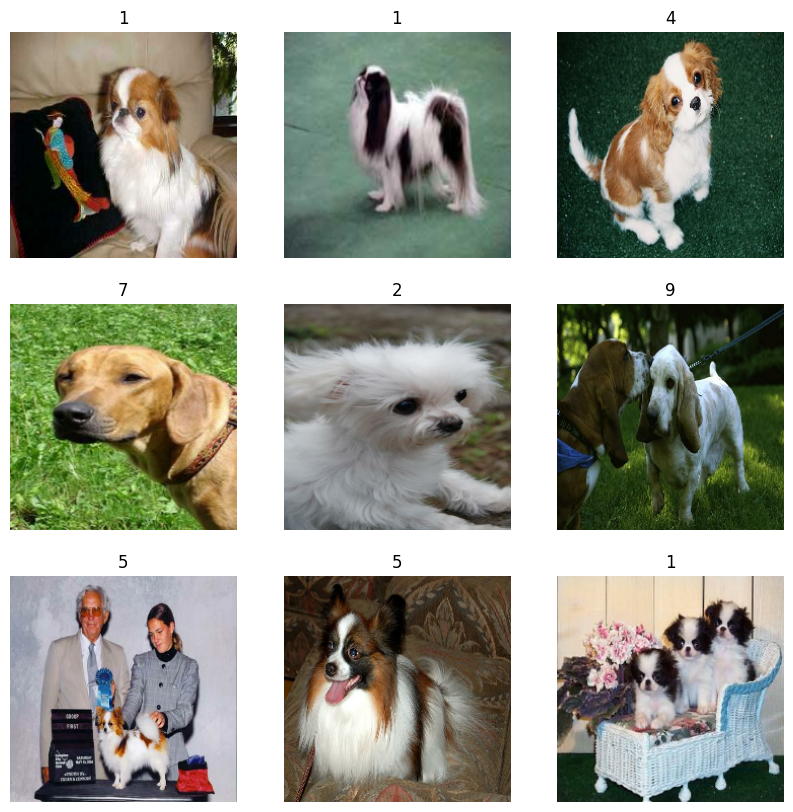

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# 2. Preprocess Data

**data augmentation**

Cela permet d'exposer le modèle à différents aspects des données d'apprentissage et de réduire le surajustement

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

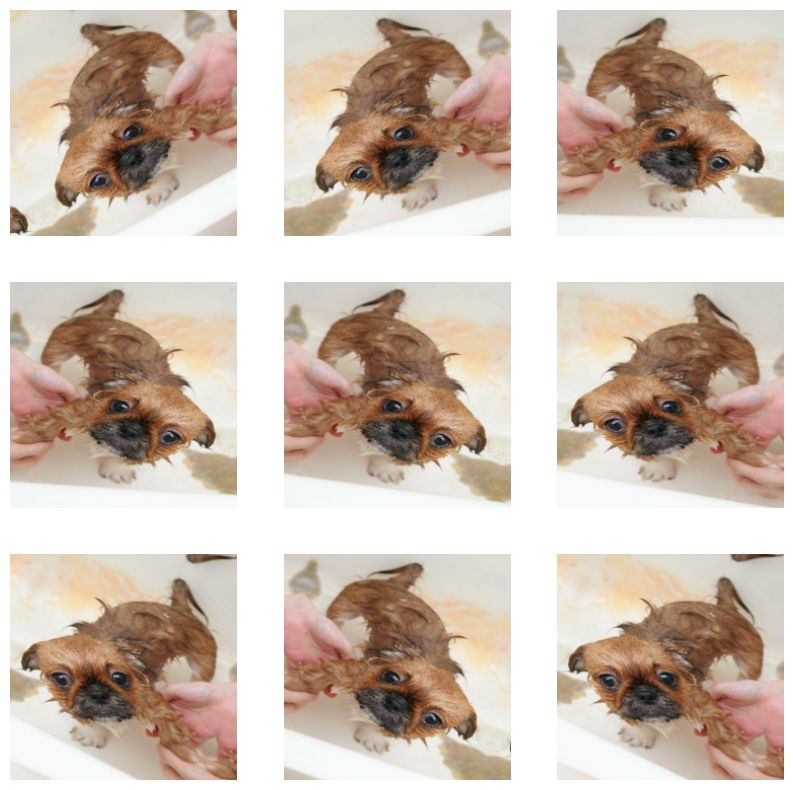

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [11]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [12]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)


# Transfer Learning

In [20]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

VGG-16 est constitué de plusieurs couches, dont 13 couches de convolution et 3 fully-connected. Il doit donc apprendre les poids de 16 couches.

In [14]:
# load model
model = VGG16()
# summarize the model
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

https://www.tensorflow.org/tutorials/images/transfer_learning?hl=fr#create_the_base_model_from_the_pre-trained_convnets

In [15]:
# Create the base model from the pre-trained model VGG16

IMG_SIZE = (224, 224)

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                          include_top=False,          # without output layer
                                          weights='imagenet',
                                          )

In [16]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
base_model.trainable = False

In [29]:
num_classes = len(class_names)

model = Sequential([
  base_model,
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(num_classes)
])

In [34]:
model.compile( loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),    # classification binary, binary_crossentropy
  optimizer='adam',
  metrics=['accuracy'])

In [48]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
47/47 [==============================] - 13s 253ms/step - loss: 0.3291 - accuracy: 0.9269 - val_loss: 1.3528 - val_accuracy: 0.8351
Epoch 2/10
47/47 [==============================] - 14s 277ms/step - loss: 0.1783 - accuracy: 0.9561 - val_loss: 1.5707 - val_accuracy: 0.7979
Epoch 3/10
47/47 [==============================] - 14s 278ms/step - loss: 0.1292 - accuracy: 0.9608 - val_loss: 1.3249 - val_accuracy: 0.8245
Epoch 4/10
47/47 [==============================] - 14s 274ms/step - loss: 0.1318 - accuracy: 0.9634 - val_loss: 1.5241 - val_accuracy: 0.8165
Epoch 5/10
47/47 [==============================] - 14s 291ms/step - loss: 0.1570 - accuracy: 0.9608 - val_loss: 1.9140 - val_accuracy: 0.7899
Epoch 6/10
47/47 [==============================] - 13s 260ms/step - loss: 0.1816 - accuracy: 0.9535 - val_loss: 1.8453 - val_accuracy: 0.7606
Epoch 7/10
47/47 [==============================] - 13s 253ms/step - loss: 0.1424 - accuracy: 0.9621 - val_loss: 1.7846 - val_accuracy: 0.8005

In [49]:
valid_loss, valid_accuracy = model.evaluate_generator(val_ds)

<ipython-input-49-9aac268120ef>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  valid_loss, valid_accuracy = model.evaluate_generator(val_ds)


In [50]:
print("Accuracy after transfer learning: {}".format(valid_accuracy))

Accuracy after transfer learning: 0.8191489577293396


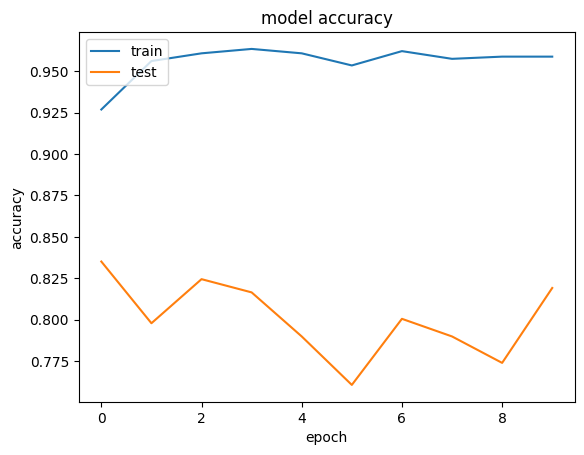

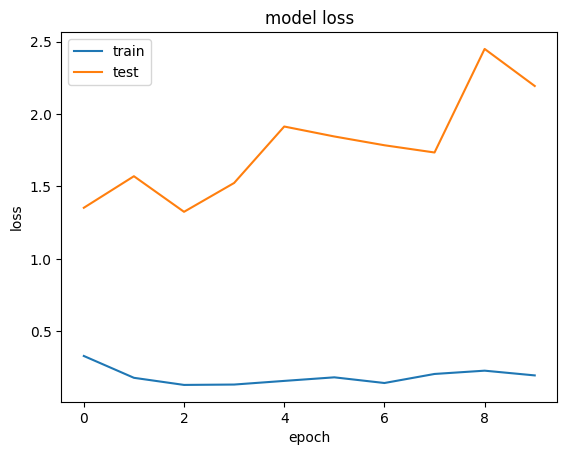

In [51]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#model_vgg16.save(vggclf.h5)

In [ ]:
from keras.model import load_model




# CNN

In [76]:
num_classes = len(class_names)

model_cnn = Sequential([
  layers.Rescaling(1./255, input_shape=(224, 224, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.AveragePooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.AveragePooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.AveragePooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.AveragePooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [77]:
model_cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=10
history = model_cnn.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
47/47 [==============================] - 13s 266ms/step - loss: 0.9039 - accuracy: 0.6948 - val_loss: 2.3207 - val_accuracy: 0.3590
Epoch 2/10
47/47 [==============================] - 13s 270ms/step - loss: 0.8628 - accuracy: 0.7134 - val_loss: 2.3516 - val_accuracy: 0.3112
Epoch 3/10
47/47 [==============================] - 14s 277ms/step - loss: 0.8413 - accuracy: 0.7281 - val_loss: 2.4561 - val_accuracy: 0.3271
Epoch 4/10
47/47 [==============================] - 13s 272ms/step - loss: 0.8285 - accuracy: 0.7327 - val_loss: 2.5459 - val_accuracy: 0.3271
Epoch 5/10
47/47 [==============================] - 14s 278ms/step - loss: 0.7992 - accuracy: 0.7420 - val_loss: 2.7635 - val_accuracy: 0.3298
Epoch 6/10
47/47 [==============================] - 13s 271ms/step - loss: 0.6892 - accuracy: 0.7660 - val_loss: 2.8185 - val_accuracy: 0.3484
Epoch 7/10
47/47 [==============================] - 15s 302ms/step - loss: 0.7062 - accuracy: 0.7693 - val_loss: 2.5618 - val_accuracy: 0.3351

In [ ]:
loss0, accuracy0 = model.evaluate(val_ds)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Dégeler les couches supérieures du modèle

In [ ]:
base_model.trainable = True

In [ ]:

# example of using a pre-trained model as a classifier
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
# load an image from file
image = load_img('dog.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
# load the model
model = model
# predict the probability across all output classes
yhat = model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

img = load_img('cat.jpg', target_size=(224, 224))  # Charger l'image
img = img_to_array(img)  # Convertir en tableau numpy
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

In [ ]:
y = model.predict(img)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

In [ ]:
from keras.applications.vgg16 import decode_predictions

# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions(y, top=3)[0])

Strategie 1 : fine-tuning total

In [ ]:
for layer in model.layers:
   layer.trainable = True

Strategie 2 : extraction de features

In [ ]:
for layer in model.layers:
   layer.trainable = False

Strategie 3 : fine-tuning partiel

In [ ]:
# Ne pas entraîner les 5 premières couches (les plus basses)
for layer in model.layers[:5]:
   layer.trainable = False

Enraînement du réseau

In [ ]:
# Compiler le modèle
new_model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

# Entraîner sur les données d'entraînement (X_train, y_train)
model_info = new_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
